# Spaceship Titanic - Transport Prediction

## Introduction

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 14.2 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import itertools
import warnings
warnings.filterwarnings('ignore')
import time

#Sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

### Column Descriptions : 
**PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.<br>
**HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.<br>
**CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.<br>
**Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.<br>
**Destination** - The planet the passenger will be debarking to.<br>
**Age** - The age of the passenger.<br>
**VIP** - Whether the passenger has paid for special VIP service during the voyage.<br>
**RoomService**, **FoodCourt**, **ShoppingMall**, **Spa**, **VRDeck** - Amounts the passenger has billed at each of the Spaceship Titanic's many luxury amenities.<br>
**Name** - The first and last names of the passenger.<br>
**Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [ ]:
df_train = pd.read_csv('/content/sample_data/train.csv')
df_test = pd.read_csv('/content/sample_data/test.csv')

In [ ]:
#corr_matrix_df= df_train.copy()
#ID_train = df_train["PassengerId"]
#ID_test = df_test["PassengerId"]
#df_train = df_train.drop("PassengerId", axis=1)
#df_test = df_test.drop("PassengerId", axis=1)
#TARGET = 'Transported'
#FEATURES = [col for col in df_train.columns if col != TARGET]

Train dataframe Overlook:

In [ ]:
df_train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


In [ ]:
df_test.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus


In [ ]:
df_train.shape

(8693, 14)

In [ ]:
df_test.shape

(4277, 13)

In [ ]:
print(df_train.isna().sum().sort_values(ascending = False))

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64


In [ ]:
print(df_test.isna().sum().sort_values(ascending = False))

FoodCourt       106
Spa             101
Cabin           100
ShoppingMall     98
Name             94
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
PassengerId       0
dtype: int64


In [ ]:
df_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [ ]:
df_test.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.000000,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000
mean,28.658146,219.266269,439.484296,177.295525,303.052443,310.710031
std,14.179072,607.011289,1527.663045,560.821123,1117.186015,1246.994742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,53.000000,78.000000,33.000000,50.000000,36.000000
max,79.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000


In [ ]:
df_train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [ ]:
df_test.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
dtype: object

## EDA

The **Target**:

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'Transported'),
 Text(0.5, 1.0, 'Transported Distribution')]

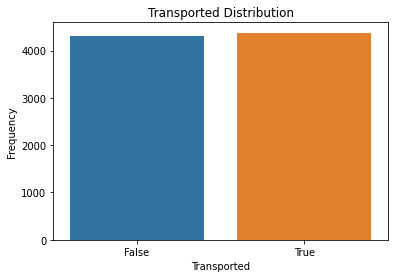

In [ ]:
ax = sns.barplot(x = df_train["Transported"].value_counts().sort_values(ascending = False).index, y = df_train["Transported"].value_counts().sort_values(ascending = False))
ax.set(xlabel='Transported', ylabel='Frequency', title ='Transported Distribution')

The Target feature is very **well balanced** !

**HomePlanet**: a textual-catagorical feature. Later, it will be converted to a catagorical feature by one-hot encoding (not label-encoding in order not to give weights to the different homeplanets)

In [ ]:
df_train['HomePlanet'].unique()

array(['Europa', 'Earth', 'Mars', nan], dtype=object)

In [ ]:
df_train['HomePlanet'].isna().sum()

201

In [ ]:
df_train['HomePlanet'].value_counts().sum()

8492

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'HomePlanet'),
 Text(0.5, 1.0, 'HomePlanet Distribution')]

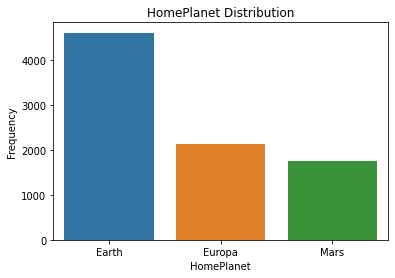

In [ ]:
ax = sns.barplot(x = df_train["HomePlanet"].value_counts().sort_values(ascending = False).index, y = df_train["HomePlanet"].value_counts().sort_values(ascending = False))
ax.set(xlabel='HomePlanet', ylabel='Frequency', title ='HomePlanet Distribution')

**CryoSleep**: a Catagorical feature. Later, it will be converted by label encoding. 

In [ ]:
df_train['CryoSleep'].unique()

array([False, True, nan], dtype=object)

In [ ]:
df_train['CryoSleep'].isna().sum()

217

In [ ]:
df_train['CryoSleep'].value_counts()

False    5439
True     3037
Name: CryoSleep, dtype: int64

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'CryoSleep'),
 Text(0.5, 1.0, 'CryoSleep Distribution')]

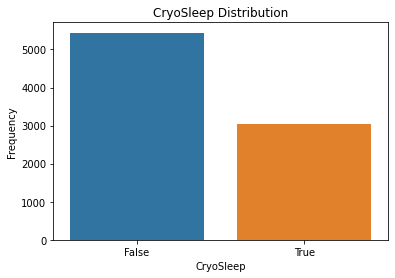

In [ ]:
ax = sns.barplot(x = df_train["CryoSleep"].value_counts().sort_values(ascending = False).index, y = df_train["CryoSleep"].value_counts().sort_values(ascending = False))
ax.set(xlabel='CryoSleep', ylabel='Frequency', title ='CryoSleep Distribution')

**Destination**: a textual-numerical feature. Later, it will be pre-proccessed and then converted to a catagorical feature by one-hot encoding. 

In [ ]:
df_train['Destination'].nunique()

3

In [ ]:
df_train['Destination'].isna().sum()

182

In [ ]:
df_train['Destination'].value_counts()

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'Destination'),
 Text(0.5, 1.0, 'Destination Distribution')]

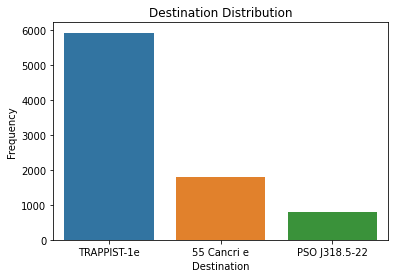

In [ ]:
ax = sns.barplot(x = df_train["Destination"].value_counts().sort_values(ascending = False).index, y = df_train["Destination"].value_counts().sort_values(ascending = False))
ax.set(xlabel='Destination', ylabel='Frequency', title ='Destination Distribution')

**Age**: a numerical feature no need to pre-proccess and convert it to a catagorical feature. 

In [ ]:
df_train['Age'].nunique()

80

In [ ]:
df_train['Age'].isna().sum()

179

In [ ]:
df_train['Age'].value_counts()

24.0    324
18.0    320
21.0    311
19.0    293
23.0    292
       ... 
72.0      4
78.0      3
79.0      3
76.0      2
77.0      2
Name: Age, Length: 80, dtype: int64

**Age - Transported** relationship:

Text(0.5, 0, 'Age (years)')

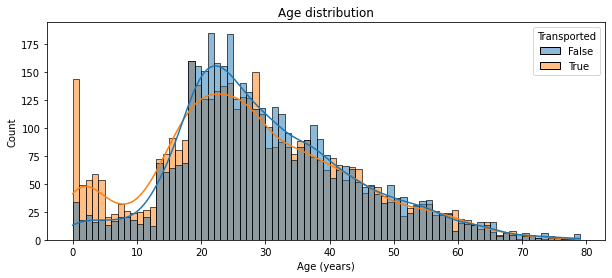

In [ ]:
plt.figure(figsize=(10,4))

sns.histplot(data=df_train, x='Age', hue='Transported', binwidth=1, kde=True)

plt.title('Age distribution')
plt.xlabel('Age (years)')

It seems that there are **three groups** of transported people:
1. 0-18 years old were more likley to be transported than not.
2. 18-40 years old were less likley to be transported than not.
3. 40-80 years old were equally likley to be transported than not.

So maybe i will create a **new feature** with three different group of ages

**VIP**: a textual-catagorical feature that will be pre-proccessed and converted by label encoding. 

In [ ]:
df_train['VIP'].nunique()

2

In [ ]:
df_train['VIP'].isna().sum()

203

In [ ]:
df_train['VIP'].value_counts()

False    8291
True      199
Name: VIP, dtype: int64

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'VIP'),
 Text(0.5, 1.0, 'VIP Distribution')]

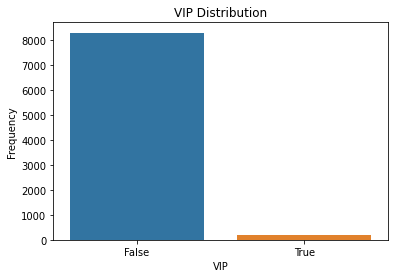

In [ ]:
ax = sns.barplot(x = df_train["VIP"].value_counts().sort_values(ascending = False).index, y = df_train["VIP"].value_counts().sort_values(ascending = False))
ax.set(xlabel='VIP', ylabel='Frequency', title ='VIP Distribution')

**RoomService**: a numrical feature that will remain as is.

In [ ]:
df_train['RoomService'].nunique()

1273

In [ ]:
df_train['RoomService'].isna().sum()

181

In [ ]:
df_train['RoomService'].value_counts()

0.0       5577
1.0        117
2.0         79
3.0         61
4.0         47
          ... 
1612.0       1
2598.0       1
632.0        1
378.0        1
745.0        1
Name: RoomService, Length: 1273, dtype: int64

In [ ]:
df_train['RoomService'].max()

14327.0

In [ ]:
df_train['RoomService'].min()

0.0

**FoodCourt**: a numrical feature that will remain as is.

In [ ]:
df_train['FoodCourt'].nunique()

1507

In [ ]:
df_train['FoodCourt'].isna().sum()

183

In [ ]:
df_train['FoodCourt'].value_counts()

0.0       5456
1.0        116
2.0         75
3.0         53
4.0         53
          ... 
3846.0       1
5193.0       1
312.0        1
827.0        1
4688.0       1
Name: FoodCourt, Length: 1507, dtype: int64

In [ ]:
df_train['FoodCourt'].max()

29813.0

In [ ]:
df_train['FoodCourt'].min()

0.0

**ShoppingMall**: a numrical feature that will remain as is.

In [ ]:
df_train['ShoppingMall'].nunique()

1115

In [ ]:
df_train['ShoppingMall'].isna().sum()

208

In [ ]:
df_train['ShoppingMall'].value_counts()

0.0       5587
1.0        153
2.0         80
3.0         59
4.0         45
          ... 
3627.0       1
2074.0       1
871.0        1
742.0        1
1872.0       1
Name: ShoppingMall, Length: 1115, dtype: int64

In [ ]:
df_train['ShoppingMall'].max()

23492.0

In [ ]:
df_train['ShoppingMall'].min()

0.0

**Spa**: a numrical feature that will remain as is.

In [ ]:
df_train['Spa'].nunique()

1327

In [ ]:
df_train['Spa'].isna().sum()

183

In [ ]:
df_train['Spa'].value_counts()

0.0       5324
1.0        146
2.0        105
5.0         53
3.0         53
          ... 
273.0        1
2581.0       1
2948.0       1
3778.0       1
1643.0       1
Name: Spa, Length: 1327, dtype: int64

In [ ]:
df_train['Spa'].max()

22408.0

In [ ]:
df_train['Spa'].min()

0.0

**VRDeck**: a numrical feature that will remain as is.

In [ ]:
df_train['VRDeck'].nunique()

1306

In [ ]:
df_train['VRDeck'].isna().sum()

188

In [ ]:
df_train['VRDeck'].value_counts()

0.0       5495
1.0        139
2.0         70
3.0         56
5.0         51
          ... 
408.0        1
876.0        1
2891.0       1
2102.0       1
3235.0       1
Name: VRDeck, Length: 1306, dtype: int64

In [ ]:
df_train['VRDeck'].max()

24133.0

In [ ]:
df_train['VRDeck'].min()

0.0

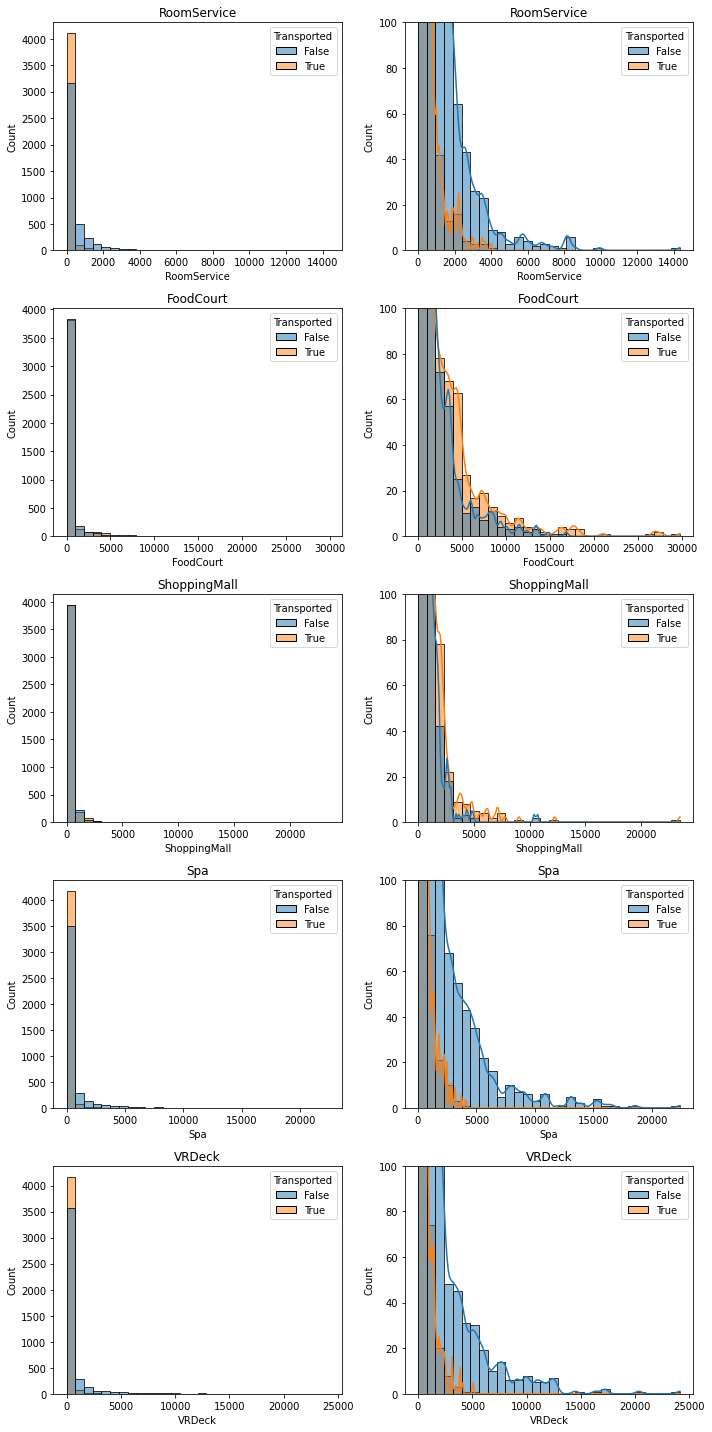

In [ ]:
# Expenditure features
exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

fig=plt.figure(figsize=(10,20))
for i, var_name in enumerate(exp_feats):
    # Left plot
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=df_train, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)
    
    # Right plot (truncated - Zoom in)
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=df_train, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,100])
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance
plt.show()

1. It is pretty clear that most of the passangers did not spend any money on Expenditure services.
2. **Passangers that were transported, barley spent any money** (maybe they were poor? maybe they did not have the time to purchase anything because they were transported early?)
3. There are a few outliers that spent way more than the others.

Steps to take according to thease findings:<br>
1. Maybe i will create a **new feature that combines all the five services above**.
2. Maybe i will create a **new binary feature that indicates if the passengers spent or did not spend any money**.

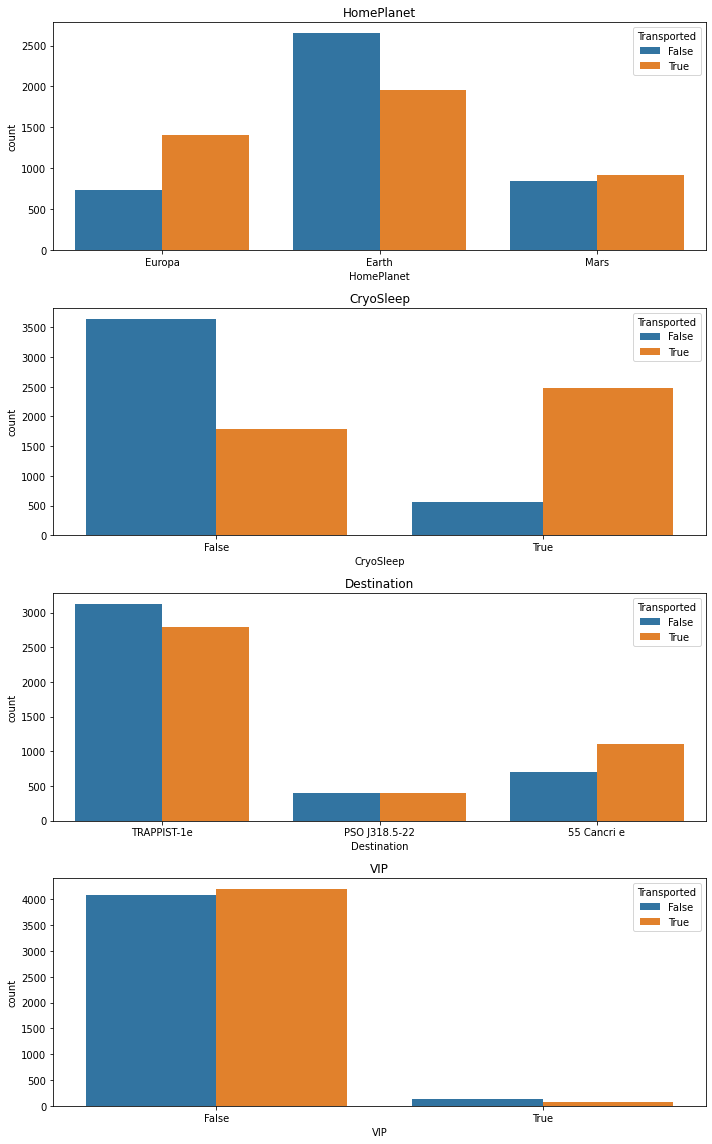

In [ ]:
# Categorical features
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Plot categorical features
fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=df_train, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

1. The CryoSleep feature seems to be very contrastive (those who were confined to their cabines are more likley to be transported than those who did not) so it will be great for the predictions.
2. The VIP feature seems to be less relevant for the predictions because he is well balanced -probably will be removed  

## Missing Values

In [ ]:
df_train.head(1)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False


In [ ]:
df_test.head(1)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning


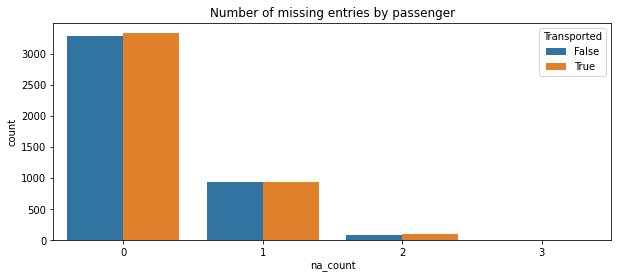

In [ ]:
df_train['na_count']=df_train.isna().sum(axis=1)
plt.figure(figsize=(10,4))
sns.countplot(data=df_train, x='na_count', hue='Transported')
plt.title('Number of missing entries by passenger')
df_train.drop('na_count', axis=1, inplace=True)

In [ ]:
df_train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [ ]:
df_test.isna().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

I'll use **mode** (most common numerical value) for filling missing values of Catagorical features and **median** for continuous features.

In [ ]:
# Find mode of each categorical feature
df_train[['HomePlanet','CryoSleep','Destination','VIP']].mode()

,HomePlanet,CryoSleep,Destination,VIP
0,Earth,False,TRAPPIST-1e,False


In [ ]:
# Impute most frequent category (for categorical data)
df_train['HomePlanet'].fillna('Earth', inplace=True)
df_test['HomePlanet'].fillna('Earth', inplace=True)

df_train['CryoSleep'].fillna(False, inplace=True)
df_test['CryoSleep'].fillna(False, inplace=True)

df_train['Destination'].fillna('TRAPPIST-1e', inplace=True)
df_test['Destination'].fillna('TRAPPIST-1e', inplace=True)

df_train['VIP'].fillna(False, inplace=True)
df_test['VIP'].fillna(False, inplace=True)

In [ ]:
# Find mode of each Expenditure features
df_train[exp_feats].mode()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Impute 0's (mode) because we will create a categorical column from this later
for col in exp_feats:
    df_train.loc[df_train[col].isna(),col]=0
    df_test.loc[df_test[col].isna(),col]=0

In [ ]:
# Impute median (for continuous data)
df_train['Age'].fillna(df_train['Age'].median(), inplace=True)
df_test['Age'].fillna(df_test['Age'].median(), inplace=True)

In [ ]:
# Impute outliers (for Cabin and Name)
df_train['Cabin'].fillna('Z/9999/Z', inplace=True)
df_test['Cabin'].fillna('Z/9999/Z', inplace=True)

df_train['Name'].fillna('No Name', inplace=True)
df_test['Name'].fillna('No Name', inplace=True)

## Feature Engineering

New Feature: **Age group**<br>


In [ ]:
# train set
df_train['Age_group']=np.nan
df_train.loc[df_train['Age']<=12,'Age_group']='Age_0-12'
df_train.loc[(df_train['Age']>12) & (df_train['Age']<18),'Age_group']='Age_13-17'
df_train.loc[(df_train['Age']>=18) & (df_train['Age']<=25),'Age_group']='Age_18-25'
df_train.loc[(df_train['Age']>25) & (df_train['Age']<=40),'Age_group']='Age_26-40'
df_train.loc[df_train['Age']>40,'Age_group']='Age_41+'

# test set
df_test['Age_group']=np.nan
df_test.loc[df_test['Age']<=12,'Age_group']='Age_0-12'
df_test.loc[(df_test['Age']>12) & (df_test['Age']<18),'Age_group']='Age_13-17'
df_test.loc[(df_test['Age']>=18) & (df_test['Age']<=25),'Age_group']='Age_18-25'
df_test.loc[(df_test['Age']>25) & (df_test['Age']<=40),'Age_group']='Age_26-40'
df_test.loc[df_test['Age']>40,'Age_group']='Age_41+'

Text(0.5, 1.0, 'Age group distribution')

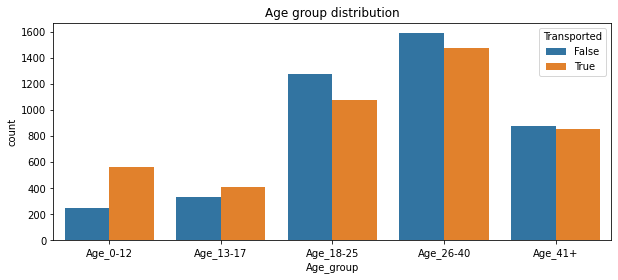

In [ ]:
# Distribution of the new feature
plt.figure(figsize=(10,4))
g=sns.countplot(data=df_train, x='Age_group', hue='Transported', order=['Age_0-12','Age_13-17','Age_18-25','Age_26-40','Age_41+'])
plt.title('Age group distribution')

New features: **Expenditure** and **Spending_or_not**

In [ ]:
exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
# train set
df_train['Expenditure']=df_train[exp_feats].sum(axis=1)
df_train['Spending_or_not']=(df_train['Expenditure']==0).astype(int)

# test set
df_test['Expenditure']=df_test[exp_feats].sum(axis=1)
df_test['Spending_or_not']=(df_test['Expenditure']==0).astype(int)

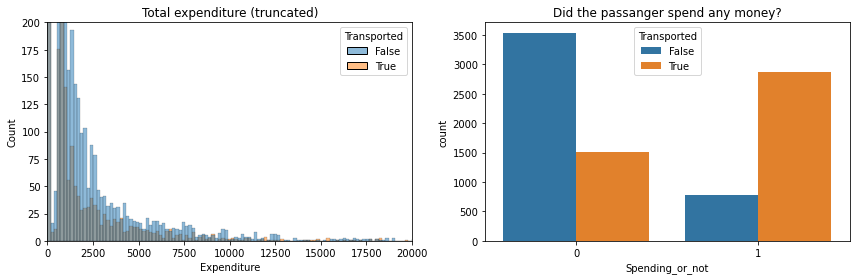

In [ ]:
# Plot distribution of new features
fig=plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=df_train, x='Expenditure', hue='Transported', bins=200)
plt.title('Total expenditure (truncated)')
plt.ylim([0,200])
plt.xlim([0,20000])

plt.subplot(1,2,2)
sns.countplot(data=df_train, x='Spending_or_not', hue='Transported')
plt.title('Did the passanger spend any money?')
fig.tight_layout()

**Cabin**: a textual-numerical feature. Later, it will be converted to a catagorical feature by one-hot encoding. 

In [ ]:
df_train['Cabin'].unique()

array(['B/0/P', 'F/0/S', 'A/0/S', ..., 'G/1499/S', 'G/1500/S', 'E/608/S'],
      dtype=object)

In [ ]:
df_train['Cabin'].nunique()

6561

In [ ]:
df_train['Cabin'].isna().sum()

0

In [ ]:
df_train['Cabin'].value_counts()

Z/9999/Z    199
G/734/S       8
C/137/S       7
B/201/P       7
G/109/P       7
           ... 
G/556/P       1
E/231/S       1
G/545/S       1
G/543/S       1
C/178/S       1
Name: Cabin, Length: 6561, dtype: int64

The cabin number represents where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.<br>
I will deconstruct this feature (or pattern) into three new representative features: **Cabin_deck**, **Cabin_number**, **Cabin_side**  

In [ ]:
# Replace NaN's with outliers for now (so we can split the feature)
df_train['Cabin'].fillna('Z/9999/Z', inplace=True)
df_test['Cabin'].fillna('Z/9999/Z', inplace=True)

In [ ]:
# train set
df_train['Cabin_deck'] = df_train['Cabin'].apply(lambda x: x.split('/')[0])
df_train['Cabin_number'] = df_train['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
df_train['Cabin_side'] = df_train['Cabin'].apply(lambda x: x.split('/')[2])

In [ ]:
# test set
df_test['Cabin_deck'] = df_test['Cabin'].apply(lambda x: x.split('/')[0])
df_test['Cabin_number'] = df_test['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
df_test['Cabin_side'] = df_test['Cabin'].apply(lambda x: x.split('/')[2])

In [ ]:
df_train.head(1)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Age_group,Expenditure,Spending_or_not,Cabin_deck,Cabin_number,Cabin_side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,Age_26-40,0.0,1,B,0,P


In [ ]:
df_test.head(1)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Age_group,Expenditure,Spending_or_not,Cabin_deck,Cabin_number,Cabin_side
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,Age_26-40,0.0,1,G,3,S


In [ ]:
df_train['Cabin_deck'].unique()

array(['B', 'F', 'A', 'G', 'Z', 'E', 'D', 'C', 'T'], dtype=object)

In [ ]:
df_train['Cabin_side'].unique()

array(['P', 'S', 'Z'], dtype=object)

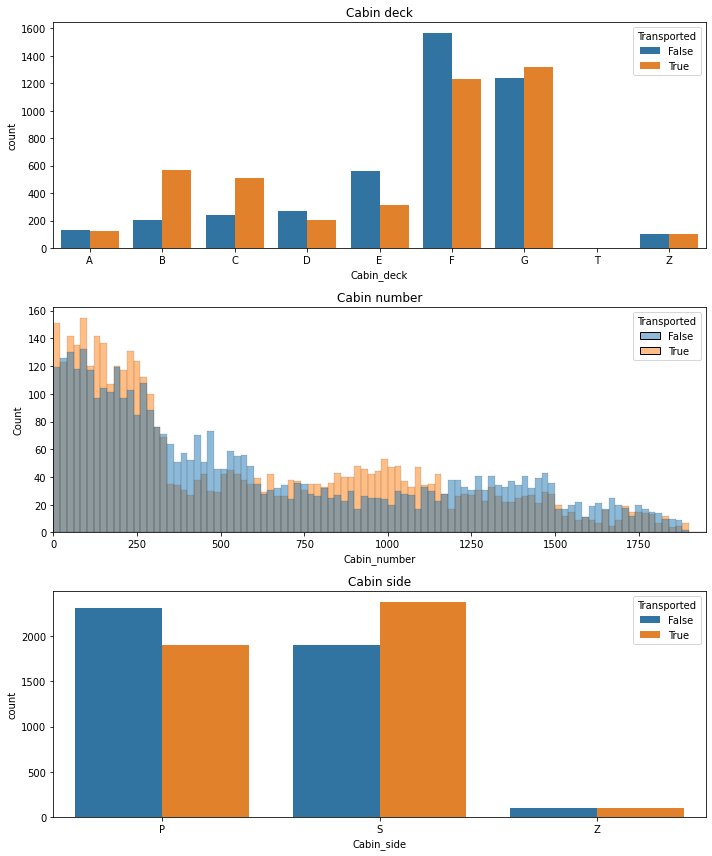

In [ ]:
# Plot distribution of new features
fig=plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.countplot(data=df_train, x='Cabin_deck', hue='Transported', order=['A','B','C','D','E','F','G','T','Z'])
plt.title('Cabin deck')

plt.subplot(3,1,2)
sns.histplot(data=df_train, x='Cabin_number', hue='Transported',binwidth=20)
plt.title('Cabin number')
plt.xlim([0,1950])

plt.subplot(3,1,3)
sns.countplot(data=df_train, x='Cabin_side', hue='Transported')
plt.title('Cabin side')
fig.tight_layout()

It appears that **Cabin_number is grouped into chunks of 300 cabins!!!**<br> This means we can compress this feature into a **categorical feature**, which indicates the chunk each passenger is in.

In [ ]:
# training set
df_train['Cabin_region1']=(df_train['Cabin_number']<300).astype(int)   # one-hot encoding
df_train['Cabin_region2']=((df_train['Cabin_number']>=300) & (df_train['Cabin_number']<600)).astype(int)
df_train['Cabin_region3']=((df_train['Cabin_number']>=600) & (df_train['Cabin_number']<900)).astype(int)
df_train['Cabin_region4']=((df_train['Cabin_number']>=900) & (df_train['Cabin_number']<1200)).astype(int)
df_train['Cabin_region5']=((df_train['Cabin_number']>=1200) & (df_train['Cabin_number']<1500)).astype(int)
df_train['Cabin_region6']=((df_train['Cabin_number']>=1500) & (df_train['Cabin_number']<1800)).astype(int)
df_train['Cabin_region7']=(df_train['Cabin_number']>=1800).astype(int)

# training set
df_test['Cabin_region1']=(df_test['Cabin_number']<300).astype(int)   # one-hot encoding
df_test['Cabin_region2']=((df_test['Cabin_number']>=300) & (df_test['Cabin_number']<600)).astype(int)
df_test['Cabin_region3']=((df_test['Cabin_number']>=600) & (df_test['Cabin_number']<900)).astype(int)
df_test['Cabin_region4']=((df_test['Cabin_number']>=900) & (df_test['Cabin_number']<1200)).astype(int)
df_test['Cabin_region5']=((df_test['Cabin_number']>=1200) & (df_test['Cabin_number']<1500)).astype(int)
df_test['Cabin_region6']=((df_test['Cabin_number']>=1500) & (df_test['Cabin_number']<1800)).astype(int)
df_test['Cabin_region7']=(df_test['Cabin_number']>=1800).astype(int)

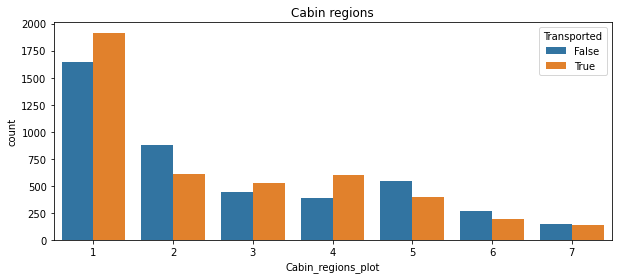

In [ ]:
# Plot distribution of new features
plt.figure(figsize=(10,4))
df_train['Cabin_regions_plot']=(df_train['Cabin_region1']+2*df_train['Cabin_region2']+3*df_train['Cabin_region3']+4*df_train['Cabin_region4']+5*df_train['Cabin_region5']+6*df_train['Cabin_region6']+7*df_train['Cabin_region7']).astype(int)
sns.countplot(data=df_train, x='Cabin_regions_plot', hue='Transported')
plt.title('Cabin regions')
df_train.drop('Cabin_regions_plot', axis=1, inplace=True)

In [ ]:
df_train.head(1)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Cabin_deck,Cabin_number,Cabin_side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,B,0,P,1,0,0,0,0,0,0


**PassangerID**: a textual-numerical feature

A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

In [ ]:
df_train['PassengerId'].unique()

array(['0001_01', '0002_01', '0003_01', ..., '9279_01', '9280_01',
       '9280_02'], dtype=object)

In [ ]:
df_train['PassengerId'].nunique()

8693

Splitting the PassangerID into new features: **Group** and **Group_size**

In [ ]:
# Group
df_train['Group'] = df_train['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
df_test['Group'] = df_test['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

In [ ]:
# Group_size (How many passangers share the same group?)
# It's important to notice that the passangers are divided into two sets (train and test) so some of them share the same group but they are not in the same dataset!

df_train['Group_size'] = df_train['Group'].map(lambda x: pd.concat([df_train['Group'],df_test['Group']]).value_counts()[x])
df_test['Group_size'] = df_test['Group'].map(lambda x: pd.concat([df_train['Group'],df_test['Group']]).value_counts()[x])

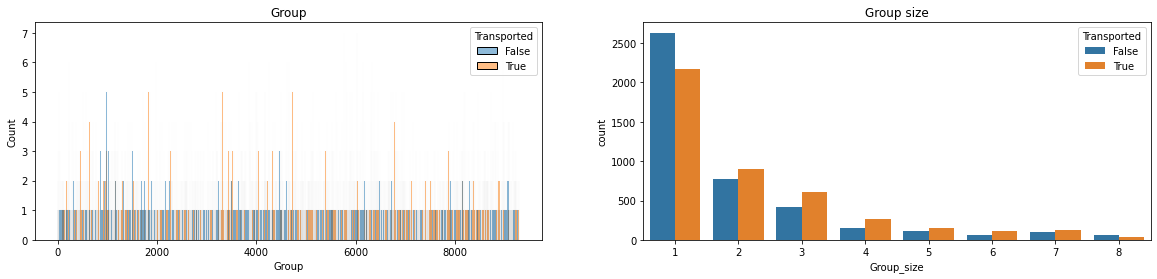

In [ ]:
# Plot distribution of new features
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
sns.histplot(data=df_train, x='Group', hue='Transported', binwidth=1)
plt.title('Group')

plt.subplot(1,2,2)
sns.countplot(data=df_train, x='Group_size', hue='Transported')
plt.title('Group size')
fig.tight_layout()

1. It seems that the Group feature has too big of a cardinallity so it will not be a proper feature to create and then to be one-hot encoded - I'll keep it out of the model.
2. The **Group_size** feature is contrastive so relevant to the model.
3. I'll create another feature that indicates whether a passanger is alone in his group or not.

(0.0, 3000.0)

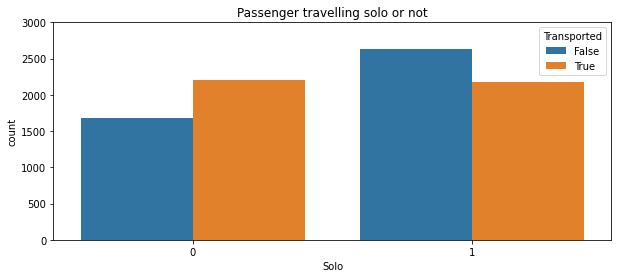

In [ ]:
# New feature
df_train['Solo']=(df_train['Group_size']==1).astype(int)
df_test['Solo']=(df_test['Group_size']==1).astype(int)

# New feature distribution
plt.figure(figsize=(10,4))
sns.countplot(data=df_train, x='Solo', hue='Transported')
plt.title('Passenger travelling solo or not')
plt.ylim([0,3000])

**Name**: a textual feature, this field will be dropped

By the last name, we can extract the **family size** onboard.

In [ ]:
df_train['Name'].unique()

array(['Maham Ofracculy', 'Juanna Vines', 'Altark Susent', ...,
       'Fayey Connon', 'Celeon Hontichre', 'Propsh Hontichre'],
      dtype=object)

In [ ]:
df_train['Name'].value_counts().sum()

8693

In [ ]:
df_train['Name'].isna().sum()

0

In [ ]:
# New feature - Surname
df_train['Surname']=df_train['Name'].str.split().str[-1]
df_test['Surname']=df_test['Name'].str.split().str[-1]

In [ ]:
df_train['Surname'].unique()

array(['Ofracculy', 'Vines', 'Susent', ..., 'Fort', 'Workmanson',
       'Sionerorly'], dtype=object)

In [ ]:
# New feature - Family_size
df_train['Family_size']=df_train['Surname'].map(lambda x:pd.concat([df_train['Surname'],df_test['Surname']]).value_counts()[x])
df_test['Family_size']=df_test['Surname'].map(lambda x:pd.concat([df_train['Surname'],df_test['Surname']]).value_counts()[x])

In [ ]:
# Set outliers (no name) to have no family
df_train.loc[df_train['Family_size']==200,'Family_size']=0
df_test.loc[df_test['Family_size']==200,'Family_size']=0

Text(0.5, 1.0, 'Family size')

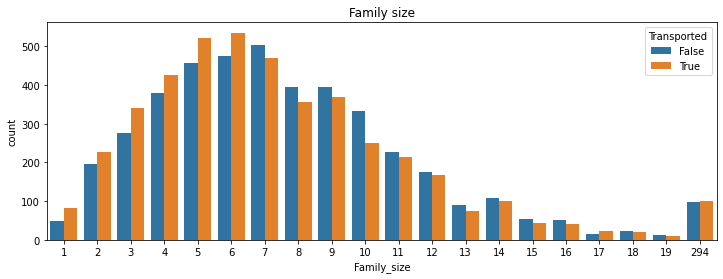

In [ ]:
# New feature distribution
plt.figure(figsize=(12,4))
sns.countplot(data=df_train, x='Family_size', hue='Transported')
plt.title('Family size')

In [ ]:
df_train.isna().sum()

PassengerId        0
HomePlanet         0
CryoSleep          0
Cabin              0
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Name               0
Transported        0
Age_group          0
Expenditure        0
Spending_or_not    0
Cabin_deck         0
Cabin_number       0
Cabin_side         0
Cabin_region1      0
Cabin_region2      0
Cabin_region3      0
Cabin_region4      0
Cabin_region5      0
Cabin_region6      0
Cabin_region7      0
Group              0
Group_size         0
Solo               0
Surname            0
Family_size        0
dtype: int64

In [ ]:
df_test.isna().sum()

PassengerId        0
HomePlanet         0
CryoSleep          0
Cabin              0
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Name               0
Age_group          0
Expenditure        0
Spending_or_not    0
Cabin_deck         0
Cabin_number       0
Cabin_side         0
Cabin_region1      0
Cabin_region2      0
Cabin_region3      0
Cabin_region4      0
Cabin_region5      0
Cabin_region6      0
Cabin_region7      0
Group              0
Group_size         0
Solo               0
Surname            0
Family_size        0
dtype: int64

## Correlation Matrix

In [ ]:
fig = px.imshow(df_train.corr() ,text_auto=True, aspect="auto" , color_continuous_scale = "viridis")
fig.show()

## Pre-proccessing & Encoding Features

In [ ]:
# Drop qualitative/redundant/high cardinality features
df_train.drop(['PassengerId', 'Cabin', 'Name', 'Group', 'Group_size', 'Cabin_number'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Cabin', 'Name', 'Group', 'Group_size', 'Cabin_number'], axis=1, inplace=True)

# Preview resulting training set
df_train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7,Solo,Surname,Family_size
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,1,Ofracculy,3
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,...,1,0,0,0,0,0,0,1,Vines,4
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,...,1,0,0,0,0,0,0,0,Susent,7
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,...,1,0,0,0,0,0,0,0,Susent,7
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,...,1,0,0,0,0,0,0,1,Santantines,9


In [ ]:
y=df_train['Transported'].copy().astype(int)
X=df_train.drop('Transported', axis=1).copy()
X_test=df_test.copy()

I'll use the **logarithm transform** in order to decrease skew in distributions, especially with large outliers. It can make it easier for algorithms to 'learn' the correct relationships.I will apply it to the expenditure features as these are heavily skewed by outliers.

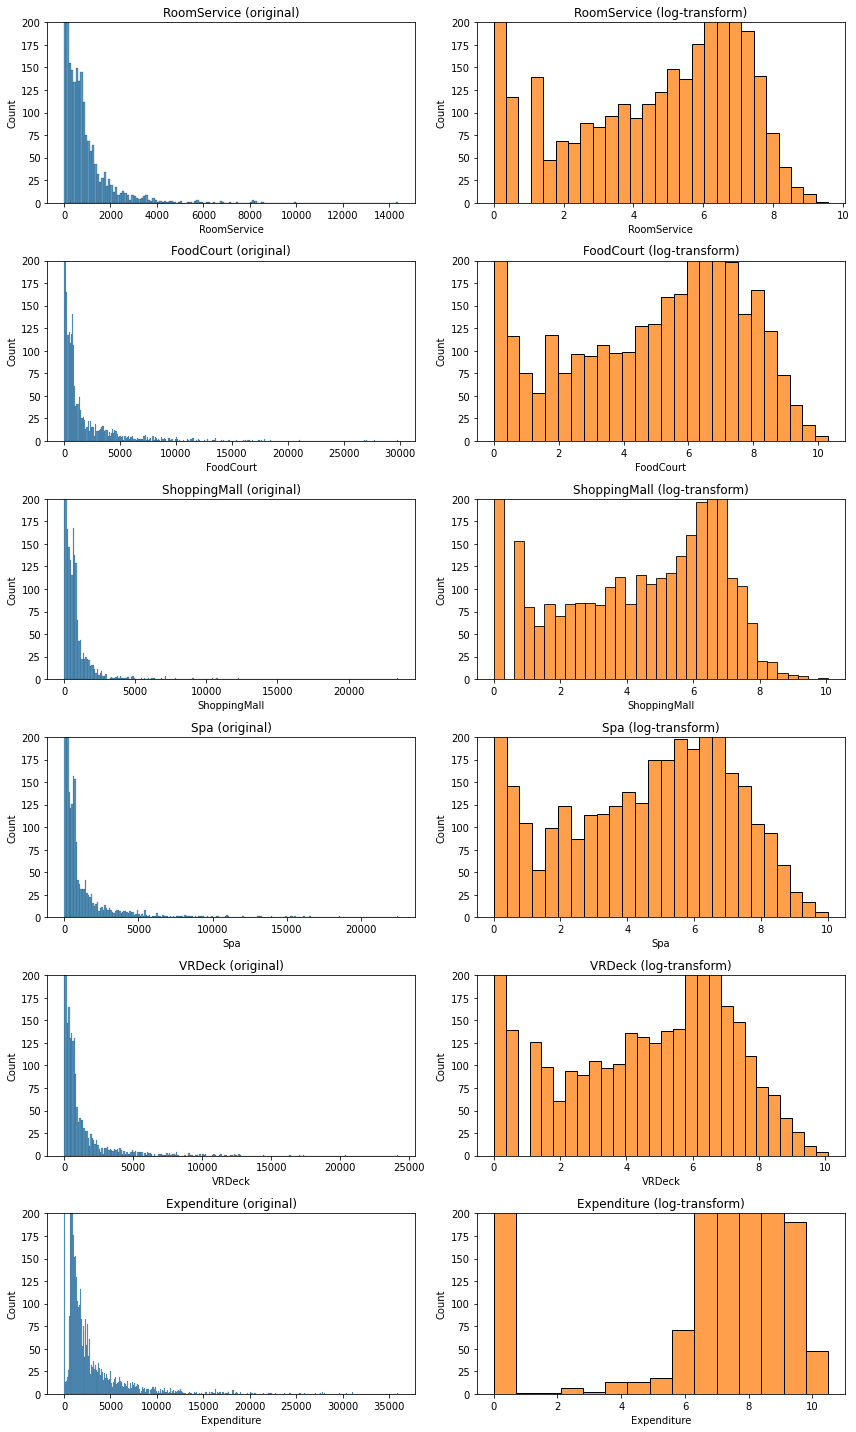

In [ ]:
# Plot log transform results
fig=plt.figure(figsize=(12,20))
for i, col in enumerate(['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']):
    plt.subplot(6,2,2*i+1)
    sns.histplot(X[col], binwidth=100)
    plt.ylim([0,200])
    plt.title(f'{col} (original)')
    
    plt.subplot(6,2,2*i+2)
    sns.histplot(np.log(1+X[col]), color='C1')
    plt.ylim([0,200])
    plt.title(f'{col} (log-transform)')
    
fig.tight_layout()
plt.show()

In [ ]:
# Apply log transform
for col in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']:
    X[col]=np.log(1+X[col])
    X_test[col]=np.log(1+X_test[col])

**Encoding and scaling**

In [ ]:
# Identify numerical and categorical columns
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

# Scale numerical data to have mean=0 and variance=1
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encode categorical data
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore',sparse=False))])

# Combine preprocessing
ct = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)],
        remainder='passthrough')

# Apply preprocessing
X = ct.fit_transform(X) # calaculating the std and mean and scaling according to them
X_test = ct.transform(X_test) 

# Print new shape
print('Training set shape:', X.shape)

Training set shape: (8693, 2260)


In [ ]:
X

array([[ 0.71194537, -0.63818082, -0.65007986, ...,  0.        ,
         0.        ,  0.        ],
       [-0.33403748,  1.09049106,  0.13503987, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.03685698,  0.75351146,  2.13985798, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.1945731 , -0.63818082, -0.65007986, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.22382004, -0.63818082,  1.72191547, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.06060632,  1.14334136,  2.23215767, ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
# split to train, val and test_split (70-15-15)
X_train, X_test_split, y_train, y_test_split = train_test_split(X, y, test_size = 0.3,random_state = 1)
X_val, X_test_split, y_val, y_test_split = train_test_split(X_test_split, y_test_split, test_size = 0.5,random_state = 1)

In [ ]:
print(f'X_train: {X_train.shape}')
print(f'X_val: {X_val.shape}')
print(f'X_test_split: {X_test_split.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_val: {y_val.shape}')
print(f'y_test_split: {y_test_split.shape}')

X_train: (6085, 2260)
X_val: (1304, 2260)
X_test_split: (1304, 2260)
y_train: (6085,)
y_val: (1304,)
y_test_split: (1304,)


In [ ]:
# Classifiers
classifiers = {
    "LogisticRegression" : LogisticRegression(random_state=0),
    "KNN" : KNeighborsClassifier(),
    #"SVC" : SVC(random_state=0, probability=True),# SVC takes too long
    "RandomForest" : RandomForestClassifier(random_state=0),
    "XGBoost" : XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss'), # XGBoost takes too long
    "LGBM" : LGBMClassifier(random_state=0),
    "CatBoost" : CatBoostClassifier(random_state=0, verbose=False)
}

# Grids for grid search
LR_grid = {'penalty': ['l1','l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],  
           'max_iter': [50, 100, 150]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

SVC_grid = {'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [4, 6, 8, 10, 12]}

boosted_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [4, 8, 12],
        'learning_rate': [0.05, 0.1, 0.15]}

# Dictionary of all grids
grid = {
    "LogisticRegression" : LR_grid,
    "KNN" : KNN_grid,
    #"SVC" : SVC_grid,
    "RandomForest" : RF_grid,
    "XGBoost" : boosted_grid,
    "LGBM" : boosted_grid,
    "CatBoost" : boosted_grid
}

Apllying **GridSearchCV** to figure out the best models (with the most accuracy)

In [ ]:
i=0
clf_best_params=classifiers.copy() # for storing the best parameters during the GridSerchCV
valid_scores=pd.DataFrame({'Classifer':classifiers.keys(), 'Validation accuracy': np.zeros(len(classifiers)), 'Training time': np.zeros(len(classifiers))})

for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

    # Train and score
    clf.fit(X_train, y_train)
    valid_scores.iloc[i,1]=clf.score(X_val, y_val) # Validation accuracy

    # Save trained model with best parameters
    clf_best_params[key]=clf.best_params_

    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i,2]=np.round((stop - start)/60, 2) # for monitoring the running time
    
    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i,2])
    print('')
    i+=1

Model: LogisticRegression
Training time (mins): 2.21

Model: KNN
Training time (mins): 3.45

Model: RandomForest
Training time (mins): 4.54

Model: XGBoost
Training time (mins): 144.76

Model: LGBM
Training time (mins): 0.73



In [ ]:
valid_scores

,Classifer,Validation accuracy,Training time
0,LogisticRegression,0.756902,2.14
1,KNN,0.774540,2.98
2,SVC,0.789110,215.64
3,RandomForest,0.746933,4.22
4,LGBM,0.809816,0.70
5,CatBoost,0.812117,40.63


In [ ]:
valid_scores.reindex(valid_scores['Validation accuracy'].sort_values(ascending = False).index)

,Classifer,Validation accuracy,Training time
5,CatBoost,0.812117,40.63
4,LGBM,0.809816,0.70
2,SVC,0.789110,215.64
1,KNN,0.774540,2.98
0,LogisticRegression,0.756902,2.14
3,RandomForest,0.746933,4.22


According to these results, the chosen classifiers for the models are: **CatBoost and LGBM**.

In [ ]:
# Show best parameters from grid search
clf_best_params

{'LogisticRegression': {'C': 0.25, 'max_iter': 50, 'penalty': 'l2'},
 'KNN': {'n_neighbors': 9, 'p': 2},
 'SVC': {'C': 1.5, 'gamma': 'scale', 'kernel': 'rbf'},
 'RandomForest': {'max_depth': 12, 'n_estimators': 50},
 'LGBM': {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 150},
 'CatBoost': {'learning_rate': 0.15, 'max_depth': 8, 'n_estimators': 200}}

## Cross Validation & Ensembling

We can finally train our best model on the whole training set using cross validation and ensembling predictions together to produce the most confident predictions.

In [ ]:
# Classifiers
best_classifiers = {
    "LGBM" : LGBMClassifier(**clf_best_params["LGBM"], random_state=0),
    "CatBoost" : CatBoostClassifier(**clf_best_params["CatBoost"], verbose=False, random_state=0),
}

Predictions are ensembled together using **soft voting**. This averages the predicted probabilities to produce the most confident predictions.

In [ ]:
len(X_test)

4277

In [ ]:
len(X_train)

6085

In [ ]:
len(X_val)

1304

In [ ]:
# Number of folds in cross validation
FOLDS=10

preds=np.zeros(len(X_test))
for key, classifier in best_classifiers.items():
    start = time.time()
    
    # 10-fold cross validation
    cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=0)
    
    score=0
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        # Get training and validation sets
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Train model
        clf = classifier
        clf.fit(X_train, y_train)

        # Make predictions and measure accuracy
        preds += clf.predict_proba(X_test)[:,1]
        score += clf.score(X_val, y_val)

    # Average accuracy    
    score=score/FOLDS
    
    # Stop timer
    stop = time.time()

    # Print accuracy and time
    print('Model:', key)
    print('Average validation accuracy:', np.round(100*score,2))
    print('Training time (mins):', np.round((stop - start)/60,2))
    print('')
    
# Ensemble predictions
preds=preds/(FOLDS*len(best_classifiers))

Model: LGBM
Average validation accuracy: 81.27
Training time (mins): 0.12

Model: CatBoost
Average validation accuracy: 81.08
Training time (mins): 1.93



Text(0.5, 0, 'Probability')

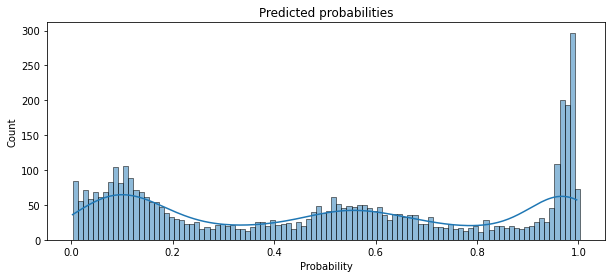

In [ ]:
plt.figure(figsize=(10,4))
sns.histplot(preds, binwidth=0.01, kde=True)
plt.title('Predicted probabilities')
plt.xlabel('Probability')

This graph shows the levels of confidence (of the classifiers), in their predictions

In [ ]:
# Proportion (in test set) we get from rounding
print(np.round(100*np.round(preds).sum()/len(preds),2))

51.81


Optimal threshold: 0.499


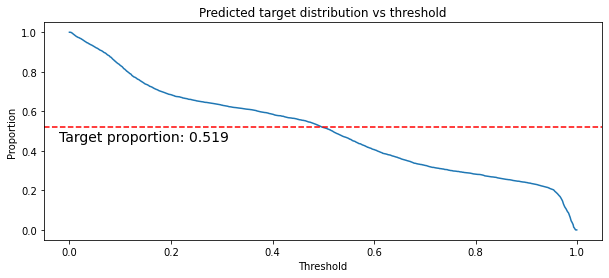

In [ ]:
# Proportion of predicted positive (transported) classes
def preds_prop(preds_arr, thresh):
    pred_classes=(preds_arr>=thresh).astype(int)
    return pred_classes.sum()/len(pred_classes)

# Plot proportions across a range of thresholds
def plot_preds_prop(preds_arr):
    # Array of thresholds
    T_array=np.arange(0,1,0.001)
    
    # Calculate proportions
    prop=np.zeros(len(T_array))
    for i, T in enumerate(T_array):
        prop[i]=preds_prop(preds_arr, T)
        
    # Plot proportions
    plt.figure(figsize=(10,4))
    plt.plot(T_array, prop)
    target_prop=0.519         # Experiment with this value
    plt.axhline(y=target_prop, color='r', linestyle='--')
    plt.text(-0.02,0.45,f'Target proportion: {target_prop}', fontsize=14)
    plt.title('Predicted target distribution vs threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Proportion')
    
    # Find optimal threshold (the one that leads to the proportion being closest to target_prop)
    T_opt=T_array[np.abs(prop-target_prop).argmin()]
    print('Optimal threshold:', T_opt)
    return T_opt
    
T_opt=plot_preds_prop(preds)

In [ ]:
# Classify test set using optimal threshold
preds_tuned=(preds>=T_opt).astype(int)

In [ ]:
submission = pd.read_csv("/content/sample_data/sample_submission.csv")

In [ ]:
len(submission['Transported'])

4277

In [ ]:
preds_tuned

array([1, 0, 1, ..., 1, 1, 1])

In [ ]:
submission['Transported'] = preds_tuned

In [ ]:
# Replace 0 to False and 1 to True
submission=submission.replace({0:False, 1:True})

In [ ]:
submission.to_csv("submission.csv", index=False)
submission.head(100)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
95,0214_02,False
96,0215_01,False
97,0218_01,False
98,0226_01,True
